# ЗАДАЧА 16
(см. http://archive.ics.uci.edu/ml/datasets/Fertility)

Авторы: Пикунов Андрей, Архипова Катя, Курилович Аня

In [1]:
import requests
import io
import itertools

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix

# Загружаем датасет

In [2]:
dataset_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00244/fertility_Diagnosis.txt'
raw_dataset = requests.get(dataset_url)
assert raw_dataset.status_code == requests.codes.ok

In [3]:
header_names = ['season',
                'age', 'chld_dis',
                'trauma',
                'surgery',
                'fever',
                'alc',
                'smoke',
                'sit',
                'class']#[str(i) for i in range(9)] + ['class']

df_raw = pd.read_csv(io.StringIO(raw_dataset.text),
                header=None,
                names = header_names)

#df_raw['class'] = df_raw['class'].map({'N': 0, 'O': 1})
#df_raw['fever'] = df_raw['fever'].map({-1: 0, 0: 1, 1: -1})

df_raw.head()

,season,age,chld_dis,trauma,surgery,fever,alc,smoke,sit,class
0,-0.33,0.69,0,1,1,0,0.8,0,0.88,N
1,-0.33,0.94,1,0,1,0,0.8,1,0.31,O
2,-0.33,0.50,1,0,0,0,1.0,-1,0.50,N
3,-0.33,0.75,0,1,1,0,1.0,-1,0.38,N
4,-0.33,0.67,1,1,0,0,0.8,-1,0.50,O


# Производим over-sampling, так как выборка сильно несбалансированная

In [4]:
cnt = df_raw['class'].value_counts()
imbalance_value = cnt[0] / cnt[-1]
print(cnt[0], cnt[1])
print("imbalance_value = {}".format(imbalance_value))

(88, 12)
imbalance_value = 7


In [5]:
df_majority = df_raw[df_raw['class']=='N']
df_minority = df_raw[df_raw['class']=='O']

In [6]:
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=cnt[0],    # to match majority class
                                 random_state=42) # reproducible results
df_minority_upsampled
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled['class'].value_counts()

N    88
O    88
Name: class, dtype: int64

# Первичный анализ данных

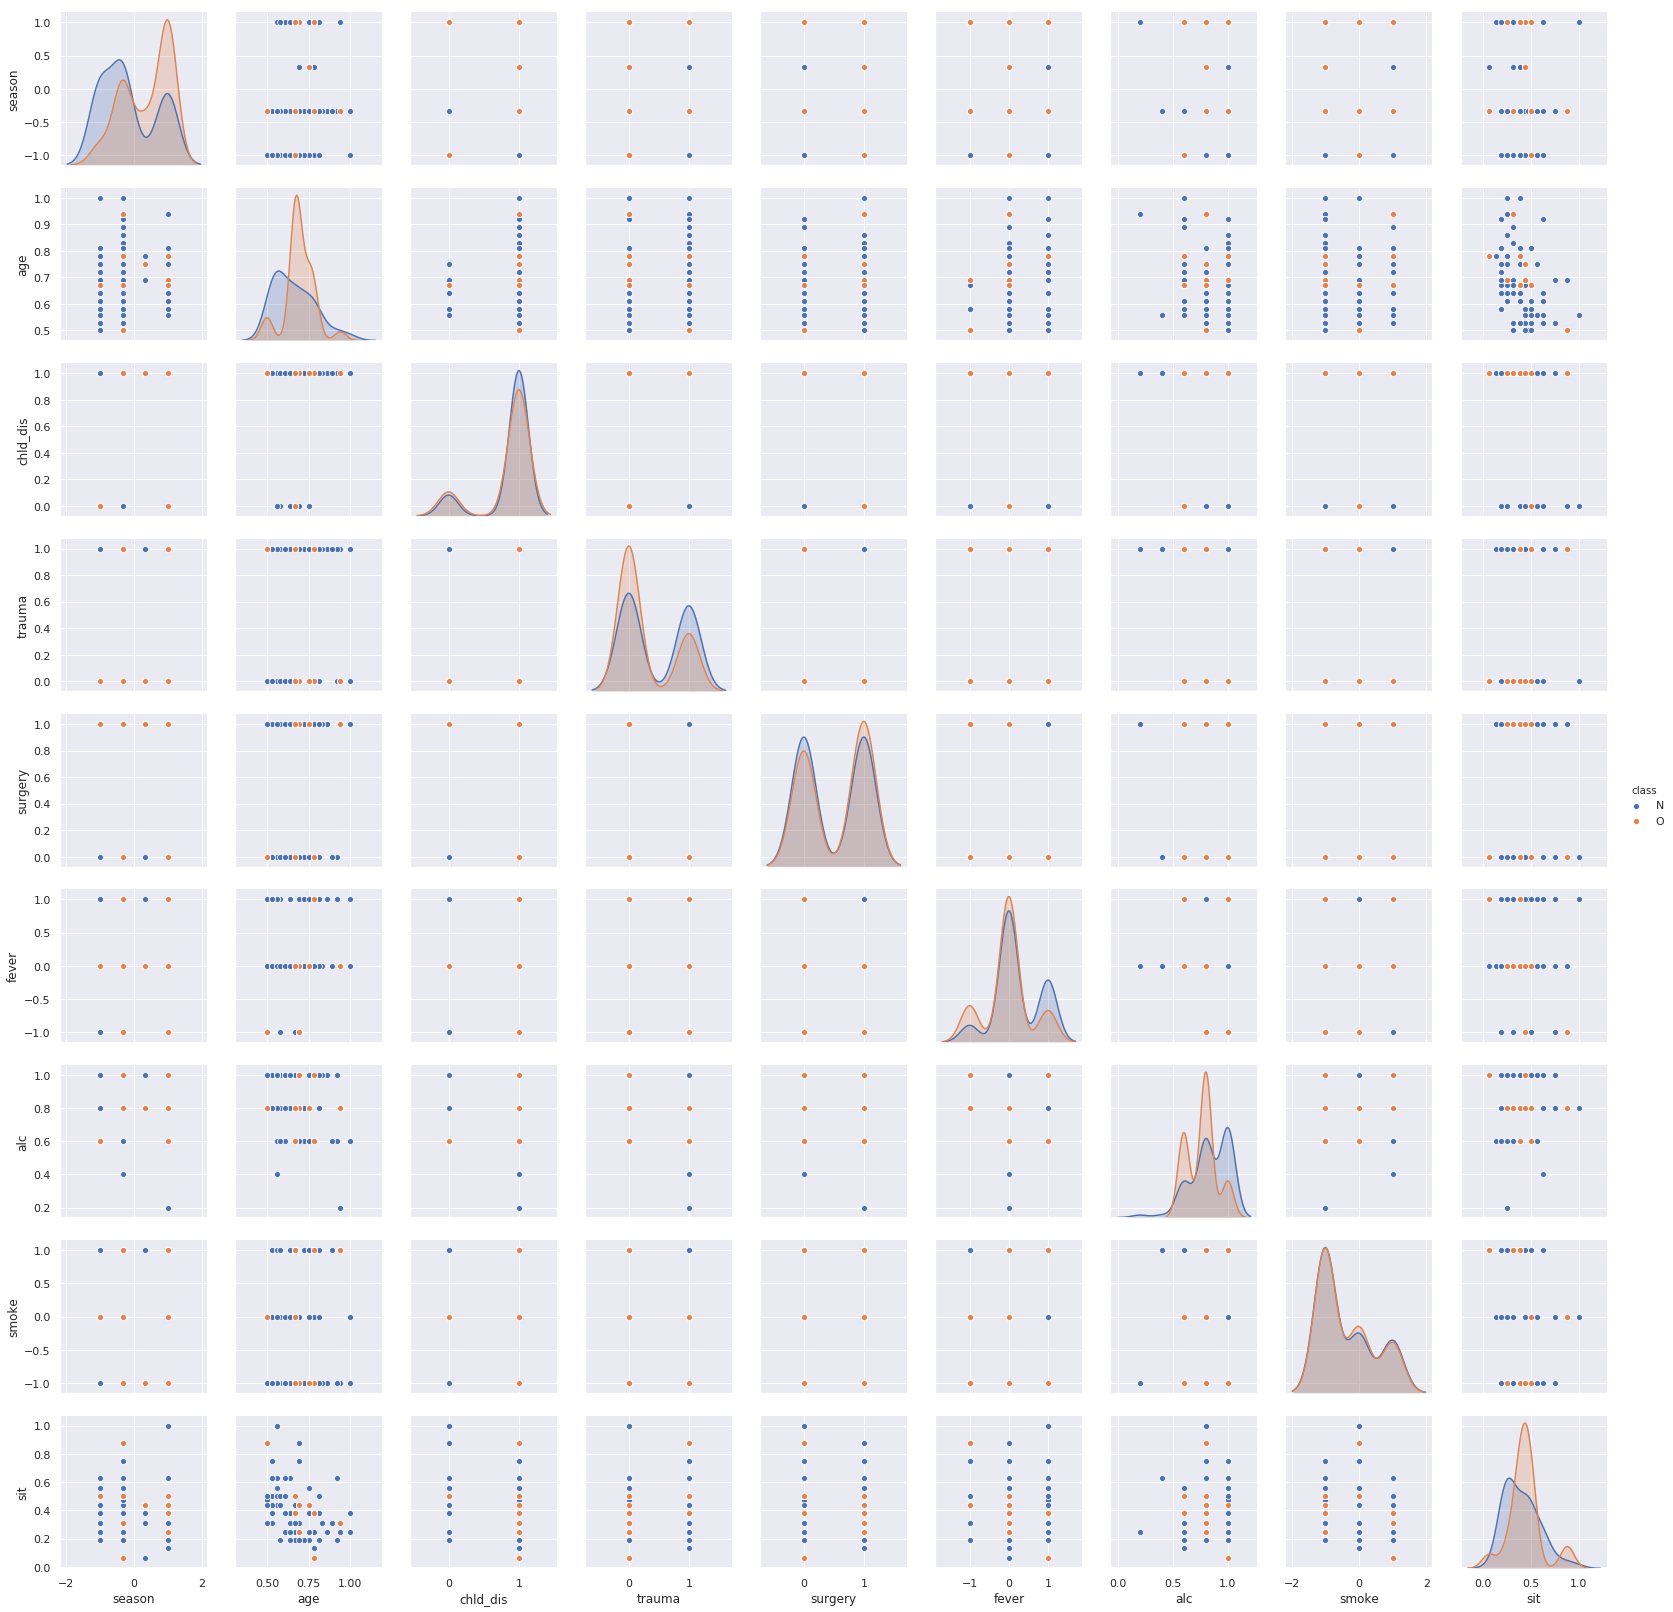

In [7]:
sns.pairplot(df_upsampled, hue='class', diag_kind='kde')

# Убираем бесполезные признаки

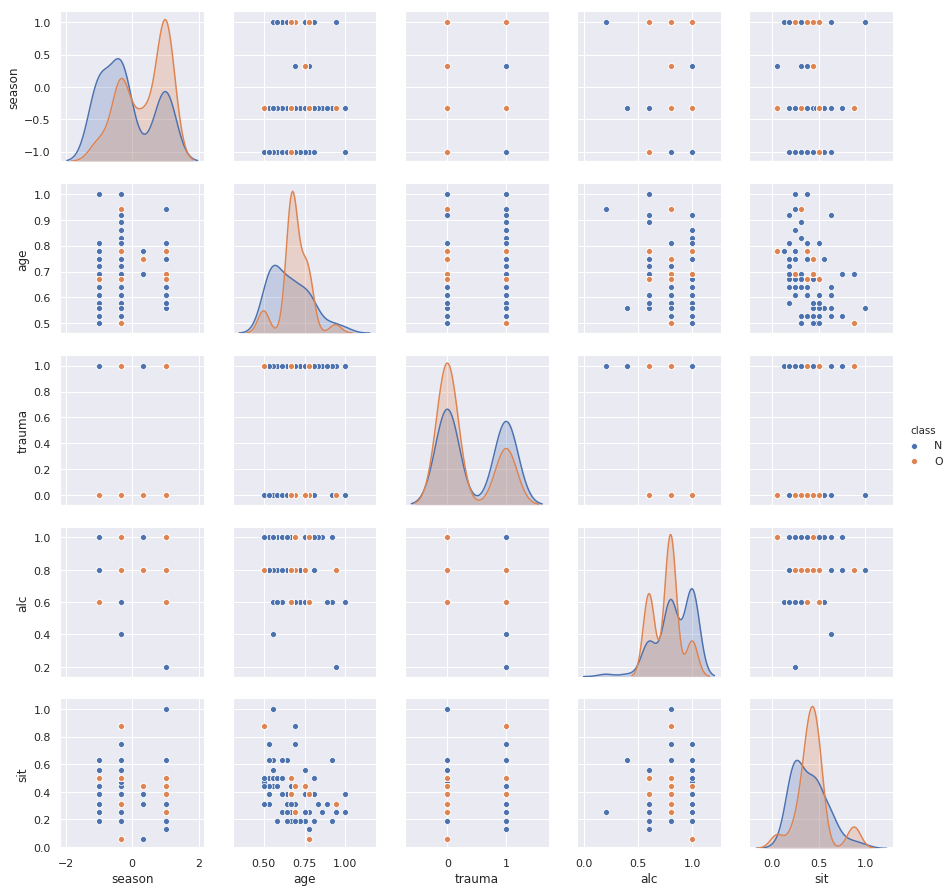

In [8]:
df_upsampled_dropped = df_upsampled.drop(columns=['chld_dis', 'surgery', 'smoke', 'fever'])
sns.pairplot(data=df_upsampled_dropped, hue='class', diag_kind='auto')

# Разбиваем на трейн и тест

In [9]:
df_raw['class'] = df_raw['class'].map({'N': 0, 'O': 1})
df_dropped = df_raw.drop(columns=['chld_dis', 'surgery', 'smoke', 'fever'])

n_samples = df_raw.shape[0]
test_size = 0.25

# shuffling
df_dropped = df_dropped.sample(frac=1, random_state=42)

# splitting
df_test, df_train = df_dropped.iloc[:int(n_samples * test_size), :], df_dropped.iloc[int(n_samples * test_size):, :]

df_train_majority = df_train[df_train['class']==0]
df_train_minority = df_train[df_train['class']==1]
maj_size = df_train_majority.shape[0]

df_train_minority_upsampled = resample(df_train_minority, 
                                       replace=True,     # sample with replacement
                                       n_samples=maj_size,    # to match majority class
                                       random_state=42) # reproducible results

df_train_upsampled = pd.concat([df_train_majority, df_train_minority_upsampled])
df_train_upsampled['class'].value_counts()

X_train = df_train_upsampled.drop(columns=['class']).copy()
y_train = df_train_upsampled['class'].copy()

x_test = df_test.drop(columns=['class']).copy()
y_test = df_test['class'].copy()

#X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    #test_size=0.3,
                                                    #random_state=42)
X_train.head(3)

,season,age,trauma,alc,sit
15,1.0,0.81,1,1.0,0.5
40,-1.0,0.53,1,0.8,0.5
96,-1.0,0.61,0,0.8,0.5


# Построение модели
(см. http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%9F%D0%B0%D1%80%D0%B7%D0%B5%D0%BD%D0%BE%D0%B2%D1%81%D0%BA%D0%BE%D0%B3%D0%BE_%D0%BE%D0%BA%D0%BD%D0%B0_%28%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D1%80%29)

In [10]:
# метрика в декатовом гиперкубе со сторонами 1
def rho(vect1, vect2):
    result = 0
    if 'seasons' in list(vect1): # обсчитываем отдельно, так как сезоны цикличны
        result += abs((vect1['season'] - vect2['season']) % 2) 
        result += np.linalg.norm(vect1.drop(columns=['seasons']) - vect2.drop(columns=['seasons']))
    else:
        result += np.linalg.norm(vect1 - vect2)
    return result

In [11]:
# различные ядра
def K1(value):
    return 3./4*(1-value**2) if 0<=value<=1 else 0

def K2(value):
    return 15./16*(1-value**2)**2 if 0<=value<=1 else 0

def K3(value):
    return (1-abs(value)) if 0<=value<=1 else 0

def K4(value):
    return 0.5 if 0<=value<=1 else 0

In [12]:
# сама модель парзеновского окна
def algorithm(idx, X, y, h, K=K1):
    sum1, sum2 = 0, 0
    for i in range(X.shape[0]-1):
        if idx != i:
            delta = K(rho(X.iloc[idx,:], X.iloc[i,:]) / h)
            if y.iloc[i] == 0:
                sum1 += delta
            else:
                sum2 += delta
    return 0 if sum1>sum2 else 1

# Обучение (подбор окна и ядра)

In [13]:
# ищем разброс расстояний в пространстве объектов
n_samples = X_train.shape[0]
h_min = rho(X_train.iloc[0,:], X_train.iloc[1,:])
h_max = 0
for i in range(n_samples):
    for j in range(n_samples):
        if i != j:
            r = rho(X_train.iloc[i,:], X_train.iloc[j,:])
            if r < h_min:
                h_min = r
            if r > h_max:
                h_max = r
print("h_range = ({0:.2f} ; {1:.2f})".format(h_min, h_max))

h_range = (0.00 ; 2.43)


In [14]:
# подбираем оптимальную ширину окна, ядро, запоминаем f1 метрику

predictions = [None for _ in range(n_samples)]

h_range = np.linspace(h_min+0.01, h_max, 10)

f1_best = None
h_best = None
K_best = None

for K in [K1, K2, K3, K4]:
    for h in h_range:
        for i in range(n_samples):
            predictions[i] = algorithm(idx=i, X=X_train, y=y_train, h=h, K=K)

        f1_current = f1_score(y_train, predictions)

        if f1_current > f1_best:
            f1_best = f1_current
            h_best = h
            K_best = K
            
    print("{} is checked".format(K.func_name))
    
print("f1_best = {0:.2f} for h_best = {1:.2f}; kernel =  {2}".format(f1_best, h_best, K_best.func_name))

K1 is checked
K2 is checked
K3 is checked
K4 is checked
f1_best = 0.86 for h_best = 0.28; kernel =  K2


In [14]:
h_best, K_best = 0.28, K2

# Прогонка на тесте

In [17]:
pred_test = [None for _ in range(x_test.shape[0])]

for i in range(x_test.shape[0]):
    pred_test[i] = algorithm(idx=i, X=X_train, y=y_train, h=h_best, K=K_best)
f1 = f1_score(y_test, pred_test)
acc = accuracy_score(y_test, pred_test)
prec = precision_score(y_test, pred_test)
rec = recall_score(y_test, pred_test)

print('accuracy = {0:.2f}'.format(acc))
print('precision = {0:.2f}'.format(prec))
print('recall = {0:.2f}'.format(rec))
print('f1 = {0:.2f}'.format(f1))

accuracy = 0.64
precision = 0.20
recall = 0.67
f1 = 0.31


In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

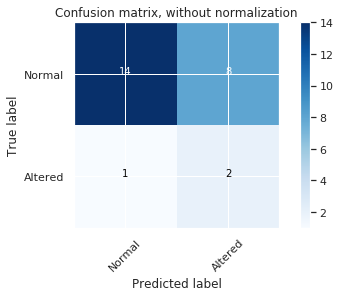

In [19]:
# Compute confusion matrix
conf_matr = confusion_matrix(y_test, pred_test)
np.set_printoptions(precision=2)
class_names = ['Normal', 'Altered']

# Plot non-normalized confusion matrix
plot_confusion_matrix(conf_matr, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()
# Plot normalized confusion matrix
#plot_confusion_matrix(conf_matr, classes=class_names, normalize=True,
                      #title='Normalized confusion matrix')

#plt.show()

# Рандомный классификатор

In [20]:
import random

sum_ = 0
for i in range(1000):
    pred_rand= [random.randint(0,1) for _ in range(n_samples)]
    sum_ += f1_score(y_train, pred_rand)
print("f1 for random classifier = {:.2f}".format(sum_/1000.))

f1 for random classifier = 0.50
